<a href="https://colab.research.google.com/github/ChrisZonghaoLi/gm_id_gf180mcu/blob/main/gm_id.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#OTA Design Using gm/id Method in GF180MCU Open-Source Process

```
Zonghao Li, September 2023
SPDX-License-Identifier: Apache-2.0
```

## 1. Environment Setup

### Install dependencies

- Wait for the kernel restart to complete.
- Click the ▷ button below to run the hidden cells to complete the setup.

In [ ]:
import os

# install conda.
CONDA_PREFIX = os.environ.get('CONDA_PREFIX', None)
if not CONDA_PREFIX:
  !python -m pip install condacolab
  import condacolab
  condacolab.install()

# install gf180mcu, get the latest branch from mabrains
!git clone https://github.com/mabrains/globalfoundries-pdk-libs-gf180mcu_fd_pr.git

# install ngspice
!conda install -c conda-forge ngspice

# Install tabulate for showing simulation results nicely during the runtime later.
!pip install tabulate

## 2. Generating LUT

Configure Ngspice simulator.

In [1]:
!mkdir simulations
!mkdir pics
!mkdir database

In [2]:
%%writefile simulations/.spiceinit
set ngbehavior=hs
set ng_nomodcheck
set num_thread=8

Writing simulations/.spiceinit


Create the netlist for generating LUT for NMOS.

In [9]:
%%writefile simulations/nfet_gm_id.spice
** sch_path: /fs1/eecg/tcc/lizongh2/gm_id/xschem/nfet_gm_id.sch
**.subckt nfet_gm_id
XM1 D G S S nfet_03v3 L=L_sweep W=W_sweep nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=M_sweep
Vg G S Vg_sweep
.save i(vg)
Vd D S 1.65
.save i(vd)
**** begin user architecture code


.param W_sweep = 4u
.param L_sweep = 0.28u
.param M_sweep = 1
.param Vg_sweep = 3.3

.control
.options savecurrents
set filetype=ascii

let L_start = 2.8e-07
let L_stop = 4e-06
let L_delta = 4.1333333333333333e-07
let L_act = L_start

* loop
while L_act le L_stop
  alterparam L_sweep = $&L_act
  reset
  op
  let gm = @m.XM1.m0[gm]
  let id = @m.XM1.m0[id]
  let gds = @m.XM1.m0[gds]
  let cgg = @m.XM1.m0[cgg]
  let vth = @m.XM1.m0[vth]
  let l = @m.XM1.m0[l]
  let w = @m.XM1.m0[w]
  let vgs = @m.XM1.m0[vgs]
  print @m.XM1.m0[gm] @m.XM1.m0[l]
  remzerovec
  save all
  write nfet_gm_id.raw
  let L_act = L_act + L_delta
  set appendwrite
end

.endc



.include /content/globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice
.lib /content/globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice typical

**** end user architecture code
**.ends
.GLOBAL GND
.end

Overwriting simulations/nfet_gm_id.spice


Create the netlist for generating LUT for PMOS.

In [8]:
%%writefile simulations/pfet_gm_id.spice
** sch_path: /fs1/eecg/tcc/lizongh2/gm_id/xschem/pfet_gm_id.sch
**.subckt pfet_gm_id
Vg G GND Vg_sweep
.save i(vg)
XM1 D G S S pfet_03v3 L=L_sweep W=W_sweep nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=M_sweep
Vd D GND 1.65
.save i(vd)
Vdd S GND 3.3
.save i(vdd)
**** begin user architecture code


.param W_sweep = 4u
.param L_sweep = 0.28u
.param M_sweep = 1
.param Vg_sweep = 3.3

.control
.options savecurrents
set filetype=ascii

let L_start = 2.8e-07
let L_stop = 4e-06
let L_delta = 4.1333333333333333e-07
let L_act = L_start

* loop
while L_act le L_stop
  alterparam L_sweep = $&L_act
  reset
  op
  let gm = @m.XM1.m0[gm]
  let id = @m.XM1.m0[id]
  let gds = @m.XM1.m0[gds]
  let cgg = @m.XM1.m0[cgg]
  let vth = @m.XM1.m0[vth]
  let l = @m.XM1.m0[l]
  let w = @m.XM1.m0[w]
  let vgs = @m.XM1.m0[vgs]
  print @m.XM1.m0[gm] @m.XM1.m0[l]
  remzerovec
  save all
  write pfet_gm_id.raw
  let L_act = L_act + L_delta
  set appendwrite
end

.endc



.include /content/globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice
.lib /content/globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice typical

**** end user architecture code
**.ends
.GLOBAL GND
.end

Overwriting simulations/pfet_gm_id.spice


Python script to simulate the netlist and generate the LUT.

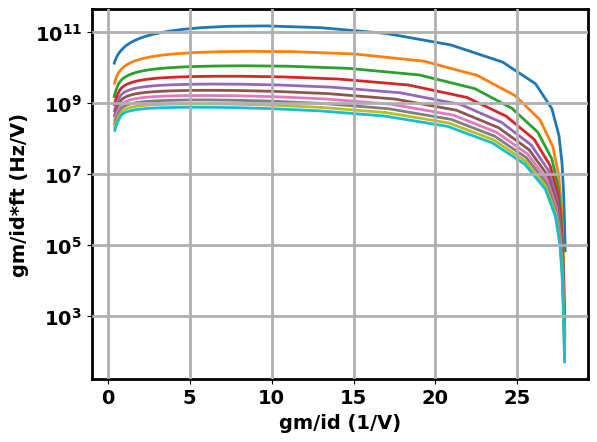

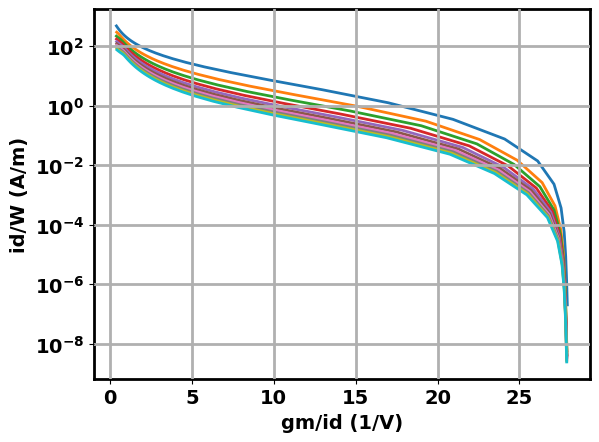

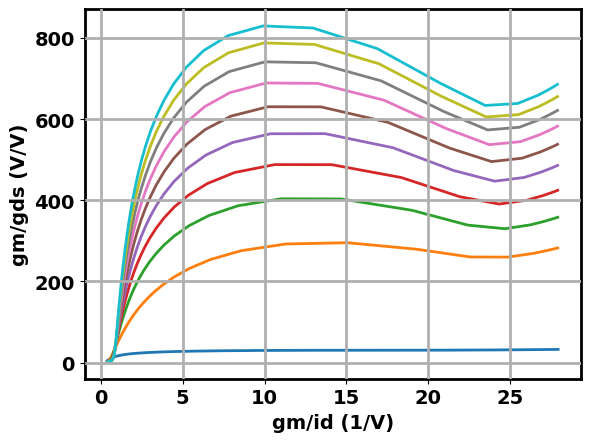

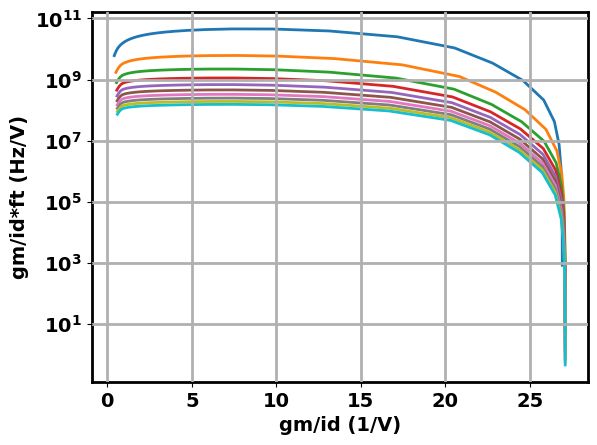

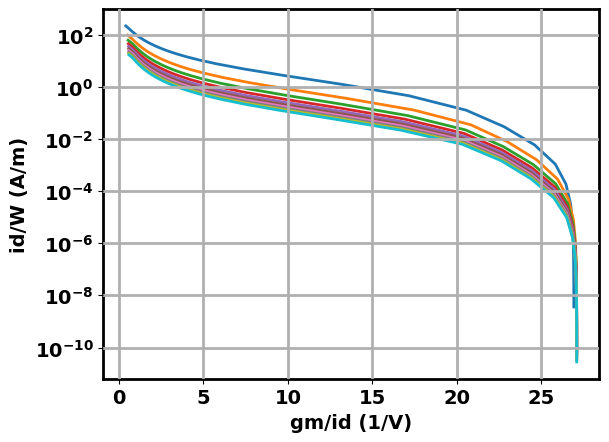

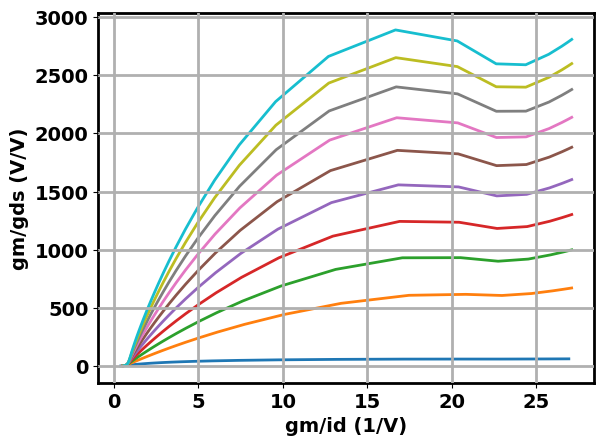

In [17]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Aug 10 16:07:12 2023

@author: lizongh2
"""
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.style.use(style='default')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.axisbelow"] = False

PWD = os.getcwd()
SPICE_NETLIST_DIR = f'{PWD}/simulations'

Vg_sweep = np.linspace(0, 3.3, 50)
L_sweep = np.linspace(0.28e-6, 4e-6, 10)
L_delta = L_sweep[2] - L_sweep[1]

""" NMOS """
nfet_gm_sweep = np.zeros((len(Vg_sweep),len(L_sweep)))
nfet_id_sweep = np.zeros((len(Vg_sweep),len(L_sweep)))
nfet_w_sweep = np.zeros((len(Vg_sweep),len(L_sweep)))
nfet_gds_sweep = np.zeros((len(Vg_sweep),len(L_sweep)))
nfet_cgg_sweep = np.zeros((len(Vg_sweep),len(L_sweep)))

# log the L sweep info to the netlist
try:
    nfet_sweep_netlist = open(f'{SPICE_NETLIST_DIR}/nfet_gm_id.spice', 'r')
    lines_nfet_sweep_netlist = nfet_sweep_netlist.readlines()
    lines_nfet_sweep_netlist[21] = f'let L_start = {L_sweep[0]}\n'
    lines_nfet_sweep_netlist[22] = f'let L_stop = {L_sweep[-1]}\n'
    lines_nfet_sweep_netlist[23] = f'let L_delta = {L_delta}\n'

    nfet_sweep_netlist = open(f'{SPICE_NETLIST_DIR}/nfet_gm_id.spice', 'w')
    nfet_sweep_netlist.writelines(lines_nfet_sweep_netlist)
    nfet_sweep_netlist.close()
except:
    print('Something is wrong')

# log the Vg info to the netlist and start the iteartion
for i in range(len(Vg_sweep)):
    nfet_sweep_netlist = open(f'{SPICE_NETLIST_DIR}/nfet_gm_id.spice', 'r')
    lines_nfet_sweep_netlist = nfet_sweep_netlist.readlines()
    lines_nfet_sweep_netlist[15] = f'.param Vg_sweep = {Vg_sweep[i]}\n'

    nfet_sweep_netlist = open(f'{SPICE_NETLIST_DIR}/nfet_gm_id.spice', 'w')
    nfet_sweep_netlist.writelines(lines_nfet_sweep_netlist)
    nfet_sweep_netlist.close()

    # run spice
    os.system(f'cd {SPICE_NETLIST_DIR}; ngspice -b -o nfet_gm_id.log nfet_gm_id.spice')

    # extract the simulated results
    nfet_gm_id = open(f'{SPICE_NETLIST_DIR}/nfet_gm_id.raw', 'r')
    lines_nfet_gm_id = nfet_gm_id.readlines()

    k = 0
    for j in range(len(lines_nfet_gm_id)):
        if lines_nfet_gm_id[j] == 'Values:\n':
            cgg = float(lines_nfet_gm_id[j+2].split('\n')[0].split('\t')[1])
            gds = float(lines_nfet_gm_id[j+3].split('\n')[0].split('\t')[1])
            gm = float(lines_nfet_gm_id[j+4].split('\n')[0].split('\t')[1])
            Id = float(lines_nfet_gm_id[j+5].split('\n')[0].split('\t')[1])
            l = float(lines_nfet_gm_id[j+6].split('\n')[0].split('\t')[1])
            vgs = float(lines_nfet_gm_id[j+8].split('\n')[0].split('\t')[1])
            vth = float(lines_nfet_gm_id[j+9].split('\n')[0].split('\t')[1])
            w = float(lines_nfet_gm_id[j+10].split('\n')[0].split('\t')[1])

            nfet_gm_sweep[i,k] = gm
            nfet_id_sweep[i,k] = Id
            nfet_w_sweep[i,k] = w
            nfet_gds_sweep[i,k] = gds
            nfet_cgg_sweep[i,k] = cgg
            k = k + 1

# plot gm/id*ft vs gm/id
nfet_gm_id = nfet_gm_sweep / nfet_id_sweep
nfet_ft = nfet_gm_sweep / (2*np.pi*nfet_cgg_sweep)
nfet_gm_id_ft = np.multiply(nfet_gm_id, nfet_ft)

plt.figure('nfet gm/id*ft vs gm/id')
plt.plot(nfet_gm_id, nfet_gm_id_ft)
plt.xlabel('gm/id (1/V)', fontweight='bold', fontsize=14)
plt.xticks(fontsize=14, weight='bold')
plt.ylabel('gm/id*ft (Hz/V)', fontweight='bold', fontsize=14)
plt.yticks(fontsize=14, fontweight='bold')
plt.yscale('log')
plt.grid(linewidth=2)
# plt.legend()
ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
plt.savefig(f'./pics/nfet_gm_id_ft.pdf', format='pdf', bbox_inches='tight')
plt.savefig(f'./pics/nfet_gm_id_ft.png', format='png', bbox_inches='tight')

# plot id/w vs gm/id
nfet_gm_id = nfet_gm_sweep / nfet_id_sweep
nfet_id_w = nfet_id_sweep / nfet_w_sweep

plt.figure('nfet id/w vs gm/id')
plt.plot(nfet_gm_id, nfet_id_w)
plt.xlabel('gm/id (1/V)', fontweight='bold', fontsize=14)
plt.xticks(fontsize=14, weight='bold')
plt.ylabel('id/W (A/m)', fontweight='bold', fontsize=14)
plt.yticks(fontsize=14, fontweight='bold')
plt.yscale('log')
plt.grid(linewidth=2)
# plt.legend()
ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
plt.savefig(f'./pics/nfet_id_w.pdf', format='pdf', bbox_inches='tight')
plt.savefig(f'./pics/nfet_id_w.png', format='png', bbox_inches='tight')

# plot self gain gm/gds vs gm/id
nfet_gm_gds = nfet_gm_sweep / nfet_gds_sweep

plt.figure('nfet gain gm/gds vs gm/id')
plt.plot(nfet_gm_id, nfet_gm_gds)
plt.xlabel('gm/id (1/V)', fontweight='bold', fontsize=14)
plt.xticks(fontsize=14, weight='bold')
plt.ylabel('gm/gds (V/V)', fontweight='bold', fontsize=14)
plt.yticks(fontsize=14, fontweight='bold')
plt.grid(linewidth=2)
# plt.legend()
ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
plt.savefig(f'./pics/nfet_gm_gds.pdf', format='pdf', bbox_inches='tight')
plt.savefig(f'./pics/nfet_gm_gds.png', format='png', bbox_inches='tight')

# save all the info
nfet_gm_id_df = pd.DataFrame(nfet_gm_id, index=Vg_sweep, columns=L_sweep)
nfet_id_w_df = pd.DataFrame(nfet_id_w, index=Vg_sweep, columns=L_sweep)
nfet_gm_gds_df = pd.DataFrame(nfet_gm_gds, index=Vg_sweep, columns=L_sweep)

nfet_gm_id_df.to_csv('./database/nfet_gm_id.csv', index=True)
nfet_id_w_df.to_csv('./database/nfet_id_w.csv', index=True)
nfet_gm_gds_df.to_csv('./database/nfet_gm_gds.csv', index=True)

""" PMOS """
pfet_gm_sweep = np.zeros((len(Vg_sweep),len(L_sweep)))
pfet_id_sweep = np.zeros((len(Vg_sweep),len(L_sweep)))
pfet_w_sweep = np.zeros((len(Vg_sweep),len(L_sweep)))
pfet_gds_sweep = np.zeros((len(Vg_sweep),len(L_sweep)))
pfet_cgg_sweep = np.zeros((len(Vg_sweep),len(L_sweep)))

# log the L sweep info to the netlist
try:
    pfet_sweep_netlist = open(f'{SPICE_NETLIST_DIR}/pfet_gm_id.spice', 'r')
    lines_pfet_sweep_netlist = pfet_sweep_netlist.readlines()
    lines_pfet_sweep_netlist[23] = f'let L_start = {L_sweep[0]}\n'
    lines_pfet_sweep_netlist[24] = f'let L_stop = {L_sweep[-1]}\n'
    lines_pfet_sweep_netlist[25] = f'let L_delta = {L_delta}\n'

    pfet_sweep_netlist = open(f'{SPICE_NETLIST_DIR}/pfet_gm_id.spice', 'w')
    pfet_sweep_netlist.writelines(lines_pfet_sweep_netlist)
    pfet_sweep_netlist.close()
except:
    print('Something is wrong')

# log the Vg info to the netlist and start the iteartion
for i in range(len(Vg_sweep)):
    pfet_sweep_netlist = open(f'{SPICE_NETLIST_DIR}/pfet_gm_id.spice', 'r')
    lines_pfet_sweep_netlist = pfet_sweep_netlist.readlines()
    lines_pfet_sweep_netlist[17] = f'.param Vg_sweep = {Vg_sweep[i]}\n'

    pfet_sweep_netlist = open(f'{SPICE_NETLIST_DIR}/pfet_gm_id.spice', 'w')
    pfet_sweep_netlist.writelines(lines_pfet_sweep_netlist)
    pfet_sweep_netlist.close()

    # run spice
    os.system(f'cd {SPICE_NETLIST_DIR}; ngspice -b -o pfet_gm_id.log pfet_gm_id.spice')

    # extract the simulated results
    pfet_gm_id = open(f'{SPICE_NETLIST_DIR}/pfet_gm_id.raw', 'r')
    lines_pfet_gm_id = pfet_gm_id.readlines()

    k = 0
    for j in range(len(lines_pfet_gm_id)):
        if lines_pfet_gm_id[j] == 'Values:\n':
            cgg = float(lines_pfet_gm_id[j+2].split('\n')[0].split('\t')[1])
            gds = float(lines_pfet_gm_id[j+3].split('\n')[0].split('\t')[1])
            gm = float(lines_pfet_gm_id[j+4].split('\n')[0].split('\t')[1])
            Id = float(lines_pfet_gm_id[j+5].split('\n')[0].split('\t')[1])
            l = float(lines_pfet_gm_id[j+6].split('\n')[0].split('\t')[1])
            vgs = float(lines_pfet_gm_id[j+9].split('\n')[0].split('\t')[1])
            vth = float(lines_pfet_gm_id[j+10].split('\n')[0].split('\t')[1])
            w = float(lines_pfet_gm_id[j+11].split('\n')[0].split('\t')[1])

            pfet_gm_sweep[i,k] = gm
            pfet_id_sweep[i,k] = Id
            pfet_w_sweep[i,k] = w
            pfet_gds_sweep[i,k] = gds
            pfet_cgg_sweep[i,k] = cgg
            k = k + 1

# plot gm/id*ft vs gm/id
pfet_gm_id = pfet_gm_sweep / pfet_id_sweep
pfet_ft = pfet_gm_sweep / (2*np.pi*pfet_cgg_sweep)
pfet_gm_id_ft = np.multiply(pfet_gm_id, pfet_ft)

plt.figure('pfet gm/id*ft vs gm/id')
plt.plot(pfet_gm_id, pfet_gm_id_ft)
plt.xlabel('gm/id (1/V)', fontweight='bold', fontsize=14)
plt.xticks(fontsize=14, weight='bold')
plt.ylabel('gm/id*ft (Hz/V)', fontweight='bold', fontsize=14)
plt.yticks(fontsize=14, fontweight='bold')
plt.yscale('log')
plt.grid(linewidth=2)
# plt.legend()
ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
plt.savefig(f'./pics/pfet_gm_id_ft.pdf', format='pdf', bbox_inches='tight')
plt.savefig(f'./pics/pfet_gm_id_ft.png', format='png', bbox_inches='tight')

# plot id/w vs gm/id
pfet_gm_id = pfet_gm_sweep / pfet_id_sweep
pfet_id_w = pfet_id_sweep / pfet_w_sweep

plt.figure('pfet id/w vs gm/id')
plt.plot(pfet_gm_id, pfet_id_w)
plt.xlabel('gm/id (1/V)', fontweight='bold', fontsize=14)
plt.xticks(fontsize=14, weight='bold')
plt.ylabel('id/W (A/m)', fontweight='bold', fontsize=14)
plt.yticks(fontsize=14, fontweight='bold')
plt.yscale('log')
plt.grid(linewidth=2)
# plt.legend()
ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
plt.savefig(f'./pics/pfet_id_w.pdf', format='pdf', bbox_inches='tight')
plt.savefig(f'./pics/pfet_id_w.png', format='png', bbox_inches='tight')

# plot self gain gm/gds vs gm/id
pfet_gm_gds =  pfet_gm_sweep / pfet_gds_sweep

plt.figure('pfet gain gm/gds vs gm/id')
plt.plot(pfet_gm_id, pfet_gm_gds)
plt.xlabel('gm/id (1/V)', fontweight='bold', fontsize=14)
plt.xticks(fontsize=14, weight='bold')
plt.ylabel('gm/gds (V/V)', fontweight='bold', fontsize=14)
plt.yticks(fontsize=14, fontweight='bold')
plt.grid(linewidth=2)
# plt.legend()
ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
plt.savefig(f'./pics/pfet_gm_gds.pdf', format='pdf', bbox_inches='tight')
plt.savefig(f'./pics/pfet_gm_gds.png', format='png', bbox_inches='tight')

# save all the info
pfet_gm_id_df = pd.DataFrame(pfet_gm_id, index=Vg_sweep, columns=L_sweep)
pfet_id_w_df = pd.DataFrame(pfet_id_w, index=Vg_sweep, columns=L_sweep)
pfet_gm_gds_df = pd.DataFrame(pfet_gm_gds, index=Vg_sweep, columns=L_sweep)

pfet_gm_id_df.to_csv('./database/pfet_gm_id.csv', index=True)
pfet_id_w_df.to_csv('./database/pfet_id_w.csv', index=True)
pfet_gm_gds_df.to_csv('./database/pfet_gm_gds.csv', index=True)




## 3. Get Some Utilities Ready

Python code that describes the subckt of netlists.

In [18]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 23 19:06:45 2023

@author: lizongh2
"""

class DiffPair:
    def __init__(self):
        self.ckt_hierarchy = (('M1','x1.XM1','pfet_03v3','m'),
                         ('M2','x1.XM2','pfet_03v3','m'),
                         ('M3','x1.XM3','nfet_03v3','m'),
                         ('M4','x1.XM4','nfet_03v3','m'),
                         ('M5','x1.XM5','pfet_03v3','m'),
                         ('M6','x1.XM6','pfet_03v3','m'),

                         ('M7','x1.XM7','pfet_03v3','m'),
                         ('M8','x1.XM8','pfet_03v3','m'),
                         ('M9','x1.XM9','pfet_03v3','m'),
                         ('M10','x1.XM10','nfet_03v3','m'),
                         ('M11','x1.XM11','nfet_03v3','m')
                        )

        self.op ={'M1':{},
                'M2':{},
                'M3':{},
                'M4':{},
                'M5':{},
                'M6':{},

                'M7':{},
                'M8':{},
                'M9':{},
                'M10':{},
                'M11':{}
                 }

class FoldedCascode:
    def __init__(self):
        self.ckt_hierarchy = (('M1','x1.XM1','pfet_03v3','m'),
                             ('M2','x1.XM2','pfet_03v3','m'),
                             ('M3','x1.XM3','nfet_03v3','m'),
                             ('M4','x1.XM4','nfet_03v3','m'),
                             ('M5','x1.XM5','nfet_03v3','m'),
                             ('M6','x1.XM6','nfet_03v3','m'),
                             ('M7','x1.XM7','nfet_03v3','m'),
                             ('M8','x1.XM8','nfet_03v3','m'),
                             ('M9','x1.XM9','nfet_03v3','m'),
                             ('M10','x1.XM10','nfet_03v3','m'),
                             ('M11','x1.XM11','pfet_03v3','m'),

                             ('M12','x1.XM12','nfet_03v3','m'),
                             ('M13','x1.XM13','nfet_03v3','m'),
                             ('M14','x1.XM14','nfet_03v3','m'),
                             ('M15','x1.XM15','nfet_03v3','m'),
                             ('M16','x1.XM16','nfet_03v3','m'),
                             ('M17','x1.XM17','pfet_03v3','m'),
                             ('M18','x1.XM18','pfet_03v3','m'),
                             ('M19','x1.XM19','pfet_03v3','m'),
                             ('M20','x1.XM20','pfet_03v3','m'),
                             ('M21','x1.XM21','pfet_03v3','m'),
                             ('M22','x1.XM22','pfet_03v3','m'),
                             ('M23','x1.XM23','pfet_03v3','m'),
                             ('M24','x1.XM24','pfet_03v3','m'),
                             ('M25','x1.XM25','pfet_03v3','m'),
                             ('M26','x1.XM26','nfet_03v3','m'),
                             ('M27','x1.XM27','nfet_03v3','m'),
                             ('M28','x1.XM28','nfet_03v3','m'),
                             ('M29','x1.XM29','nfet_03v3','m'),
                             ('M30','x1.XM30','pfet_03v3','m')
                            )


        self.op ={'M1':{},
                'M2':{},
                'M3':{},
                'M4':{},
                'M5':{},
                'M6':{},
                'M7':{},
                'M8':{},
                'M9':{},
                'M10':{},
                'M11':{},
                'M12':{},
                'M13':{},
                'M14':{},
                'M15':{},
                'M16':{},
                'M17':{},
                'M18':{},
                'M19':{},
                'M20':{},
                'M21':{},
                'M22':{},
                'M23':{},
                'M24':{},
                'M25':{},
                'M26':{},
                'M27':{},
                'M28':{},
                'M29':{},
                'M30':{}
                 }


class TwoStage:
    def __init__(self):
        self.ckt_hierarchy = (('M1','x1.XM1','pfet_03v3','m'),
                         ('M2','x1.XM2','pfet_03v3','m'),
                         ('M3','x1.XM3','nfet_03v3','m'),
                         ('M4','x1.XM4','nfet_03v3','m'),

                         ('M5','x1.XM5','nfet_03v3','m'),
                         ('M6','x1.XM6','pfet_03v3','m'),

                         ('M7','x1.XM7','pfet_03v3','m'),
                         ('M8','x1.XM8','pfet_03v3','m'),

                        )

        self.op ={'M1':{},
                'M2':{},
                'M3':{},
                'M4':{},
                'M5':{},
                'M6':{},

                'M7':{},
                'M8':{}
                 }


Python script that is used to extract the .OP device parameters.

In [21]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 10 17:28:00 2023

@author: lizongh2

This script is used to generate block of spice commands that used to
access BSIM4 device internal device parameters.

This one is for GF180MCU process (stack option C)

You can just run it once to generate the script for the DCOP
"""

import os

class DeviceParams(object):
    def __init__(self, ckt_hierarchy, warning_msg=False):
        self.ckt_hierarchy = ckt_hierarchy
        self.dev_names_mos = (
            'nfet_03v3',
            'nfet_03v3_dss',
            'nfet_05v0',
            'nfet_06v0',
            'nfet_06v0_nvt',
            'pfet_03v3',
            'pfet_03v3_dss',
            'pfet_06v0',
            )
        self.dev_names_r = (
            'nplus_u',
            'npolyf_u',
            'pplus_u',
            'ppolyf_u',
            )
        self.dev_names_c = (
            'cap_mim_2p0fF',
            'cap_nmos_03v3',
            'cap_nmos_06v0',
            'cap_pmos_03v3',
            'cap_pmos_06v0',
            )

        if warning_msg == True:
            for i in self.ckt_hierarchy:
                dev_name = i[2]
                dev_type = i[3]
                if dev_type == 'm' or dev_type == 'M':
                    if dev_name not in self.dev_names_mos:
                        print(f'This MOS is not in GF180MCU PDK. A valid device name can be {self.dev_names_mos}.')
                elif dev_type == 'r' or dev_type == 'R':
                    if dev_name not in self.dev_names_r:
                        print(f'This resistor is not in GF180MCU PDK. A valid device name can be {self.dev_names_r}.')
                elif dev_type == 'c' or dev_type == 'C':
                    if dev_name not in self.dev_names_c:
                        print(f'This capacitor is not in GF180MCU PDK. A valid device name can be {self.dev_names_c}.')
                elif dev_type == 'i' or dev_type == 'I':
                    None
                elif dev_type == 'v' or dev_type == 'V':
                    None
                else:
                    print('You have a device type that cannot be found here...')

        # 45 attributes for mos
        self.params_mos = (
            'gmbs',
            'gm',
            'gds',
            'vdsat',
            'vth',
            'id',
            'ibd',
            'ibs',
            'gbd',
            'gbs',
            'vbs',
            'vgs',
            'vds',
            'cgg',
            'cgs',
            'cgd',
            'cbg',
            'cbd',
            'cbs',
            'cdg',
            'cdd',
            'cds',
            'csg',
            'csd',
            'css',
            'cgb',
            'cdb',
            'csb',
            'cbb'
            )

        # 'capbd',
        # 'capbs',
        # 'qg',
        # 'qb',
        # 'qs',
        # 'qinv',
        # 'qdef',
        # 'gcrg',
        # 'gtau',
        # 'isub',
        # 'igidl',
        # 'igisl',
        # 'igs',
        # 'igd',
        # 'igb',
        # 'igcs',

        # 20 attributes for r
        self.params_r = (
            'r',
            'ac',
            'temp',
            'dtemp',
            'l',
            'w',
            'm',
            'tc',
            'tc1',
            'tc2',
            'scale',
            'noise',
            'i',
            'p',
            'sens_dc',
            'sens_real',
            'sens_imag',
            'sens_mag',
            'sens_ph',
            'sens_cplx'
            )
        # 18 attributes for c
        self.params_c = (
            'capacitance',
            'cap',
            'c',
            'ic',
            'temp',
            'dtemp',
            'w',
            'l',
            'm',
            'scale',
            'i',
            'p',
            'sens_dc',
            'sens_real',
            'sens_imag',
            'sens_mag',
            'sens_ph',
            'sens_cplx'
            )
        # 8 attributes for i source
        self.params_i = (
            'dc',
            'acmag',
            'acphase',
            'acreal',
            'acimag',
            'v',
            'p',
            'current'
            )
        # 7 attributes for v source
        self.params_v = (
            'dc',
            'acmag',
            'acphase',
            'acreal',
            'acimag',
            'i',
            'p',
            )

    def gen_dev_params(self, file_name):
        lines = []
        write_file = ''
        for i in self.ckt_hierarchy:
            symbol_name = i[0]
            subckt = i[1]
            dev_name = i[2]
            dev_type = i[3]

            if dev_type == 'm' or dev_type == 'M':
                for param in self.params_mos:
                    if subckt == '':
                        raise ValueError('In this PDK, transistor is instantiated as a subckt! Subckt is missing here.')
                    else:
                        if dev_name in self.dev_names_mos:
                            line = f'let {param}_{symbol_name}=@m.{subckt}.m0[{param}]'
                        else:
                            raise ValueError(f'This device {symbol_name} is not defined in this PDK.')
                    lines.append(line)
                    write_file = write_file + f'{param}_{symbol_name} '
                lines.append('')
            elif dev_type == 'r' or dev_type == 'R':
                for param in self.params_r:
                    if subckt == '':
                        raise ValueError('In this PDK, resistor is instantiated as a subckt! Subckt is missing here.')
                    else:
                        if dev_name in self.dev_names_r:
                            raise ValueError('It is not straightforward to extract resistance info from this PDK, \
                                             so for resistance just use Rsheet * L / W / M for approximation. Remove the resistors from the ckt_hierarchy.')
                        else:
                            raise ValueError('This device is not defined in this PDK.')
                    lines.append(line)
                    write_file = write_file + f'{param}_{symbol_name} '
                lines.append('')
            elif dev_type == 'c' or dev_type == 'C':
                for param in self.params_c:
                    if subckt == '':
                        raise ValueError('In this PDK, capacitor is instantiated as a subckt! Subckt is missing here.')
                    else:
                        if dev_name in self.dev_names_c:
                            raise ValueError('It is not straightforward to extract resistance info from this PDK, \
                                             so for resistance just use Csheet * (L * W) * M for approximation. Remove the capacitors from the ckt_hierarchy.')
                        else:
                            raise ValueError('This device is not defined in this PDK.')
                    lines.append(line)
                    write_file = write_file + f'{param}_{symbol_name} '
                lines.append('')
            elif dev_type == 'i' or dev_type == 'I':
                for param in self.params_i:
                    if subckt == '':
                        line = f'let {param}_{symbol_name}=@{dev_name}[{param}]'
                    else:
                        line = f'let {param}_{symbol_name}=@i.{subckt}.{dev_name}[{param}]'
                    lines.append(line)
                    write_file = write_file + f'{param}_{symbol_name} '
                lines.append('')
            elif dev_type == 'v' or dev_type == 'V':
                for param in self.params_v:
                    if subckt == '':
                        line = f'let {param}_{symbol_name}=@{dev_name}[{param}]'
                    else:
                        line = f'let {param}_{symbol_name}=@v.{subckt}.{dev_name}[{param}]'
                    lines.append(line)
                    write_file = write_file + f'{param}_{symbol_name} '
                lines.append('')
            else:
                None

        lines.append(f'write {file_name} ' + write_file)

        return lines



if __name__ == '__main__':
    ckt_hierarchy = DiffPair().ckt_hierarchy
    dev_params_script = DeviceParams(ckt_hierarchy).gen_dev_params(file_name='diff_pair_op.raw')

    with open(f'{SPICE_NETLIST_DIR}/diff_pair_dev_params.spice', 'w') as f:
        for line in dev_params_script:
            f.write(f'{line}\n')

    ckt_hierarchy = FoldedCascode().ckt_hierarchy
    dev_params_script = DeviceParams(ckt_hierarchy).gen_dev_params(file_name='folded_cascode_op.raw')

    with open(f'{SPICE_NETLIST_DIR}/folded_cascode_dev_params.spice', 'w') as f:
        for line in dev_params_script:
            f.write(f'{line}\n')


    ckt_hierarchy = TwoStage().ckt_hierarchy
    dev_params_script = DeviceParams(ckt_hierarchy).gen_dev_params(file_name='two_stage_op.raw')

    with open(f'{SPICE_NETLIST_DIR}/two_stage_dev_params.spice', 'w') as f:
        for line in dev_params_script:
            f.write(f'{line}\n')



Python script that is used to extract the post-simulation results.

In [28]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Nov  2 16:20:56 2022

@author: zonghao
"""


class OutputParser(DeviceParams):

    def __init__(self, CktGraph):
        self.ckt_hierarchy = CktGraph.ckt_hierarchy
        self.op = CktGraph.op
        super().__init__(self.ckt_hierarchy)

    def ac(self, file_name):
        # AC analysis result parser
        try:
            ldo_tb_ac = open(f'{SPICE_NETLIST_DIR}/{file_name}', 'r')
            lines_ac = ldo_tb_ac.readlines()
            freq = []
            Vout_mag = []
            Vout_ph = []
            for line in lines_ac:
                Vac = line.split(' ')
                Vac = [i for i in Vac if i != '']
                freq.append(float(Vac[0]))
                Vout_mag.append(float(Vac[1]))
                Vout_ph.append(float(Vac[3]))
            return freq, Vout_mag, Vout_ph
        except:
            print("Simulation errors, no .AC simulation results.")

    def dc(self, file_name):
        # DC analysis result parser
        try:
            ldo_tb_dc = open(f'{SPICE_NETLIST_DIR}/{file_name}', 'r')
            lines_dc = ldo_tb_dc.readlines()
            Vin_dc = []
            Vout_dc = []
            for line in lines_dc:
                Vdc = line.split(' ')
                Vdc = [i for i in Vdc if i != '']
                Vin_dc.append(float(Vdc[0]))
                Vout_dc.append(float(Vdc[1]))

            dx = Vin_dc[1] - Vin_dc[0]
            dydx = np.gradient(Vout_dc, dx)

            return Vin_dc, Vout_dc
        except:
            print("Simulation errors, no .OP simulation results.")

    def tran(self, file_name):
        # Transient analysis result parser
        try:
            ldo_tb_tran = open(f'{SPICE_NETLIST_DIR}/{file_name}', 'r')
            lines_tran = ldo_tb_tran.readlines()
            time = []
            Vout_tran = []
            for line in lines_tran:
                line = line.split(' ')
                line = [i for i in line if i != '']
                time.append(float(line[0]))
                Vout_tran.append(float(line[1]))

            return time, Vout_tran
        except:
                print("Simulation errors, no .TRAN simulation results.")


    def dcop(self, file_name):
        # DCOP analysis result parser
        try:
            ldo_tb_op = open(f'{SPICE_NETLIST_DIR}/{file_name}', 'r')
            # ldo_tb_op = open(f'{file_dir}', 'r')
            lines_op = ldo_tb_op.readlines()
            for index, line in enumerate(lines_op):
                if line == "Values:\n":
                    # print(f"{index}") # catch the index where the dcop values start
                    start_idx = index
            _lines_op = lines_op[start_idx+2:-1]
            lines_op = []
            for _line in _lines_op:
                lines_op.append(float(_line.split('\n')[0].split('\t')[1]))

            num_dev = len(self.ckt_hierarchy)
            num_dev_params_mos = len(self.params_mos)
            num_dev_params_r = len(self.params_r)
            num_dev_params_c = len(self.params_c)
            num_dev_params_i = len(self.params_i)
            num_dev_params_v = len(self.params_v)

            idx = 0
            for i in range(num_dev):
                dev_type = self.ckt_hierarchy[i][3]
                if dev_type == 'm' or dev_type == 'M':
                    for j in range(num_dev_params_mos):
                        param = self.params_mos[j]
                        self.op[list(self.op)[i]][param] = lines_op[idx+j]
                    idx = idx + num_dev_params_mos
                elif dev_type == 'r' or dev_type == 'R':
                    for j in range(num_dev_params_r):
                        param = self.params_r[j]
                        self.op[list(self.op)[i]][param] = lines_op[idx+j]
                    idx = idx + num_dev_params_r
                elif dev_type == 'c' or dev_type == 'C':
                    for j in range(num_dev_params_c):
                        param = self.params_c[j]
                        self.op[list(self.op)[i]][param] = lines_op[idx+j]
                    idx = idx + num_dev_params_c
                elif dev_type == 'i' or dev_type == 'I':
                    for j in range(num_dev_params_i):
                        param = self.params_i[j]
                        self.op[list(self.op)[i]][param] = lines_op[idx+j]
                    idx = idx + num_dev_params_i
                elif dev_type == 'v' or dev_type == 'V':
                    for j in range(num_dev_params_v):
                        param = self.params_v[j]
                        self.op[list(self.op)[i]][param] = lines_op[idx+j]
                    idx = idx + num_dev_params_v
                else:
                    None

            return self.op
        except:
            print("Simulation errors, no .OP simulation results.")


## 4. Diff-pair OTA with Constant-gm Biasing Design Using gm/id Method

In [23]:
%%writefile simulations/diff_pair_tb.spice
** sch_path: /fs1/eecg/tcc/lizongh2/gm_id/xschem/diff_pair_tb.sch
**.subckt diff_pair_tb
x1 net1 net3 net2 Vout GND diff_pair
V1 net1 GND 3.3
.save i(v1)
C1 Vout GND 10p m=1
V2 net2 GND 1.1
.save i(v2)
V3 net3 GND dc 1.1 ac 1
.save i(v3)
**** begin user architecture code

.include /content/globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice
.lib /content/globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice typical



.include /content/simulations/diff_pair_vars.spice

.control
.options savecurrents
set filetype=ascii
set units=degrees
save all

.include /content/simulations/diff_pair_analysis.spice
.endc


**** end user architecture code
**.ends

* expanding   symbol:  /fs1/eecg/tcc/lizongh2/gm_id/xschem/diff_pair.sym # of pins=5
** sym_path: /fs1/eecg/tcc/lizongh2/gm_id/xschem/diff_pair.sym
** sch_path: /fs1/eecg/tcc/lizongh2/gm_id/xschem/diff_pair.sch
.subckt diff_pair Vdd Vp Vn Vout Vss
*.ipin Vp
*.ipin Vn
*.opin Vout
*.iopin Vdd
*.iopin Vss
XM1 net1 Vp net2 Vdd pfet_03v3 L=L_M1 W=W_M1 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM2 Vout Vn net2 Vdd pfet_03v3 L=L_M1 W=W_M1 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM3 net1 net1 Vss Vss nfet_03v3 L=L_M3 W=W_M3 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM4 Vout net1 Vss Vss nfet_03v3 L=L_M4 W=W_M4 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM5 net2 net3 Vdd Vdd pfet_03v3 L=L_M5 W=W_M5 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM6 net3 net3 Vdd Vdd pfet_03v3 L=L_M6 W=W_M6 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM7 net4 net4 Vdd Vdd pfet_03v3 L=L_M7 W=W_M7 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM8 net5 net4 net6 Vdd pfet_03v3 L=L_M8 W=W_M8 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=4
XM9 net5 net5 Vss Vss nfet_03v3 L=L_M9 W=W_M9 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM10 net4 net5 Vss Vss nfet_03v3 L=L_M10 W=W_M10 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
R1 Vdd net6 Rbias m=1
XM11 net3 net5 Vss Vss nfet_03v3 L=L_M11 W=W_M11 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
.ends

.GLOBAL GND
.end

Writing simulations/diff_pair_tb.spice


Simulation setup.

In [24]:
%%writefile simulations/diff_pair_analysis.spice
ac dec 10 1 10G
plot vdb(Vout) vp(Vout)
wrdata diff_pair_vout.raw mag(Vout) vp(Vout)
op
.include /content/simulations/diff_pair_dev_params.spice



Writing simulations/diff_pair_analysis.spice


Design variables.

In [25]:
%%writefile simulations/diff_pair_vars.spice
.param W_M1=7.989041123914854e-05 L_M1=2.8e-07
.param W_M2=W_M1 L_M2=L_M1
.param W_M3=8.425478601245572e-05 L_M3=1.52e-06
.param W_M4=W_M3 L_M4=L_M3
.param W_M5=7.583891759545482e-05 L_M5=1.1066666666666667e-06
.param W_M6=7.583891759545482e-05 L_M6=1.1066666666666667e-06
.param W_M7=W_M1 L_M7=L_M1
.param W_M8=W_M7 L_M8=L_M7
.param W_M9=W_M3 L_M9=L_M3
.param W_M10=W_M3 L_M10=L_M3
.param W_M11=W_M3 L_M11=L_M3
.param Rbias=900



Writing simulations/diff_pair_vars.spice


Python script for running the simulations.

In [30]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Aug 10 18:32:14 2023

@author: lizongh2
"""

import os
import numpy as np
import pandas as pd
from copy import deepcopy


# specs
GBW = 20e6 # 20 MHz
CL = 10e-12 # 10pF load

''' load database '''
# PMOS
pfet_gm_id = pd.read_csv('./database/pfet_gm_id.csv', index_col=0).to_numpy()
pfet_id_w = pd.read_csv('./database/pfet_id_w.csv', index_col=0).to_numpy()
pfet_gm_gds = pd.read_csv('./database/pfet_gm_gds.csv', index_col=0).to_numpy()
L_sweep = pd.read_csv('./database/pfet_gm_gds.csv', index_col=0).columns.to_numpy().astype(float)
Vgs_sweep = pd.read_csv('./database/pfet_gm_gds.csv', index_col=0).index.to_numpy().astype(float)
# NMOS
nfet_gm_id = pd.read_csv('./database/nfet_gm_id.csv', index_col=0).to_numpy()
nfet_id_w = pd.read_csv('./database/nfet_id_w.csv', index_col=0).to_numpy()
nfet_gm_gds = pd.read_csv('./database/nfet_gm_gds.csv', index_col=0).to_numpy()

''' Find L and W of the gain stage (M1 and M2, PMOS) '''
# fist, from GBW, choose gm for input stage
Gm = GBW * 2*np.pi*(1+0.2)*CL # 0.2 is a factor to include parasitics
# next, pick the appropriate gm/id number for input stage (from gm/id*ft vs gm/id plot)
# usually, this can be conditioned on the power consumption
gm_id_M1 = 15
# calculate current
Id = Gm / gm_id_M1
# caculate gm
gm_M1 = gm_id_M1 * Id
# find out the W by looking at the id_w database/plot
_idx = np.array([np.abs(pfet_gm_id[:,i]-gm_id_M1).argmin() for i in range(np.shape(pfet_gm_id)[1])])
_W_M1 = Id/np.array([pfet_id_w[i,j] for i,j in zip(_idx, list(range(np.shape(pfet_gm_id)[1])))])
_gds_M1 = gm_M1/np.array([pfet_gm_gds[i,j] for i,j in zip(_idx, list(range(np.shape(pfet_gm_gds)[1])))])
# The W and L are
W_L_M1 = np.stack([_W_M1, L_sweep], axis=1)
W_M1, L_M1 = W_L_M1[0]
# gds
gds_M1 = _gds_M1[0]

''' Find L and W of the active load (M3 and M4, NMOS) '''
# for current source, use smaller gm/id value. for better noise performance
gm_id_M3 = 10
# caculate gm
gm_M3 = gm_id_M3 * Id
# We know Id from M1 already
_idx = np.array([np.abs(nfet_gm_id[:,i]-gm_id_M3).argmin() for i in range(np.shape(nfet_gm_id)[1])])
_W_M3 = Id/np.array([nfet_id_w[i,j] for i,j in zip(_idx, list(range(np.shape(nfet_gm_id)[1])))])
_gds_M3 = gm_M3/np.array([nfet_gm_gds[i,j] for i,j in zip(_idx, list(range(np.shape(nfet_gm_gds)[1])))])
# The W and L are
W_L_M3 = np.stack([_W_M3, L_sweep], axis=1)
# for better matching, we need some large L values
W_M3, L_M3 = W_L_M3[3]
# gds
gds_M3 = _gds_M3[3]

''' Find L and W of the current mirror (M5, PMOS) '''
# for current source, use smaller gm/id value. for better noise performance
gm_id_M5 = 4
# We know Id from M1 already, remember now it is 2*Id
_idx = np.array([np.abs(pfet_gm_id[:,i]-gm_id_M5).argmin() for i in range(np.shape(pfet_gm_id)[1])])
_W_M5 = 2*Id/np.array([pfet_id_w[i,j] for i,j in zip(_idx, list(range(np.shape(pfet_gm_id)[1])))])
# The W and L are
W_L_M5 = np.stack([_W_M5, L_sweep], axis=1)
# for better matching, we need some large L values
W_M5, L_M5 = W_L_M5[2]

''' Find L and W of the current mirror (M6, PMOS) '''
# For simplicity, we just now copy M5 to M6
W_M6 = deepcopy(W_M5)
L_M6 = deepcopy(L_M5)
# Ibias is therefore 2*Id
Ibias = 2*Id

''' Find L and W of M7 and M8 '''
# Same as M1, but make sure the multiplier of M8 is 4 times of M7
''' Find L and W of M9, M10, and M11 '''
# Same as M3. You can optionally increase their L as long as they are in saturation region

''' update the netlist '''
try:
    # open the netlist of the testbench
    diff_pair_tb_vars = open(f'{SPICE_NETLIST_DIR}/diff_pair_vars.spice', 'r')
    lines = diff_pair_tb_vars.readlines()

    lines[0] = f'.param W_M1={W_M1} L_M1={L_M1}\n'
    lines[1] = f'.param W_M2=W_M1 L_M2=L_M1\n'
    lines[2] = f'.param W_M3={W_M3} L_M3={L_M3}\n'
    lines[3] = f'.param W_M4=W_M3 L_M4=L_M3\n'
    lines[4] = f'.param W_M5={W_M5} L_M5={L_M5}\n'
    lines[5] = f'.param W_M6={W_M6} L_M6={L_M6}\n'
    lines[6] = f'.param W_M7=W_M1 L_M7=L_M1\n'
    lines[7] = f'.param W_M8=W_M7 L_M8=L_M7\n'
    lines[8] = f'.param W_M9=W_M3 L_M9=L_M3\n'
    lines[9] = f'.param W_M10=W_M3 L_M10=L_M3\n'
    lines[10] = f'.param W_M11=W_M3 L_M11=L_M3\n'
    lines[11] = f'.param Rbias=900\n'

    ldo_tb_vars = open(f'{SPICE_NETLIST_DIR}/diff_pair_vars.spice', 'w')
    ldo_tb_vars.writelines(lines)
    ldo_tb_vars.close()

    print('*** Netlist updated! ***')
    os.system(f'cd {SPICE_NETLIST_DIR}; ngspice -b -o diff_pair_tb.log diff_pair_tb.spice')
    print('*** SPICE simulations finished! ***')
except:
    print('ERROR')

''' Post-processing the diff-pair results '''
sim_results = OutputParser(DiffPair())
op_results = sim_results.dcop('diff_pair_op.raw')
# check current
Id_M1_sim = op_results['M1']['id'] # compare this with Id
Id_M3_sim = op_results['M3']['id'] # compare this with 2*Id
Id_M5_sim = op_results['M5']['id'] # compare this with 2*Id
gm_M1_sim = op_results['M1']['gm']
gm_M3_sim = op_results['M3']['gm']
gm_M5_sim = op_results['M5']['gm']

Id_M6_sim = op_results['M6']['id']
gm_M6_sim = op_results['M6']['gm']

Id_M7_sim = op_results['M7']['id']
gm_M7_sim = op_results['M7']['gm']

Id_M8_sim = op_results['M8']['id']
Id_M9_sim = op_results['M9']['id']
Id_M11_sim = op_results['M11']['id']
Id_M10_sim = op_results['M10']['id']

# check gm/id
gm_id_M1_sim = gm_M1_sim / Id_M1_sim # compare this with gm_id_M1
gm_id_M3_sim = gm_M3_sim / Id_M3_sim # compare this with gm_id_M3
gm_id_M5_sim = gm_M5_sim / Id_M5_sim # compare this with gm_id_M5

# check gain
Vout = sim_results.ac('diff_pair_vout.raw')
freq = np.array(Vout[0])
Vout_mag = np.array(Vout[1])
Vout_deg = np.array(Vout[2])
Vout_dc = Vout_mag[0] # already in dB
gain = 20*np.log10(gm_M1 / (gds_M1 + gds_M3)) # compare this with Vout_dc

# check ft
Vout_ft = freq[np.argmin(abs(Vout_mag-1))] # compare this with GBW

from tabulate import tabulate
print(tabulate(
    [
        ['Id_M1 (uA)', Id*1e6, Id_M1_sim*1e6],
        ['Id_M3 (uA)', Id*1e6, Id_M3_sim*1e6],
        ['Id_M5 (uA)', 2*Id*1e6, Id_M5_sim*1e6],

        ['gm/id_M1 (1/V)', gm_id_M1, gm_id_M1_sim],
        ['gm/id_M3 (1/V)', gm_id_M3, gm_id_M3_sim],
        ['gm/id_M5 (1/V)', gm_id_M5, gm_id_M5_sim],

        ['gain (dB)', gain, Vout_dc],
        ['GBW (MHz)', GBW/1e6, Vout_ft/1e6]

        ],
    headers=['params', 'gm/id method', 'SPICE simulation'], tablefmt='orgtbl', numalign='right', floatfmt=".2f"
    ))



*** Netlist updated! ***
*** SPICE simulations finished! ***
| params         |   gm/id method |   SPICE simulation |
|----------------+----------------+--------------------|
| Id_M1 (uA)     |         100.53 |             102.69 |
| Id_M3 (uA)     |         100.53 |             102.69 |
| Id_M5 (uA)     |         201.06 |             205.38 |
| gm/id_M1 (1/V) |          15.00 |              12.86 |
| gm/id_M3 (1/V) |          10.00 |              10.66 |
| gm/id_M5 (1/V) |           4.00 |               4.23 |
| gain (dB)      |          34.62 |              35.69 |
| GBW (MHz)      |          20.00 |              19.95 |


## 5. Folded-Cascode OTA with High-Swing Current Mirror Biasing

Load the netlist.

In [32]:
%%writefile simulations/folded_cascode_tb.spice
** sch_path: /fs1/eecg/tcc/lizongh2/gm_id/xschem/folded_cascode_tb.sch
**.subckt folded_cascode_tb
x1 net3 net2 net1 Vout GND folded_cascode
V2 net1 GND 1.1
.save i(v2)
V3 net2 GND dc 1.1 ac 1
.save i(v3)
V1 net3 GND 3.3
.save i(v1)
C1 Vout GND 10p m=1
**** begin user architecture code

.include /content/globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice
.lib /content/globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice typical



.include /content/simulations/folded_cascode_vars.spice

.control
.options savecurrents
set filetype=ascii
set units=degrees
save all

.include /content/simulations/folded_cascode_analysis.spice
.endc


**** end user architecture code
**.ends

* expanding   symbol:  /fs1/eecg/tcc/lizongh2/gm_id/xschem/folded_cascode.sym # of pins=5
** sym_path: /fs1/eecg/tcc/lizongh2/gm_id/xschem/folded_cascode.sym
** sch_path: /fs1/eecg/tcc/lizongh2/gm_id/xschem/folded_cascode.sch
.subckt folded_cascode Vdd Vp Vn Vout Vss
*.ipin Vp
*.ipin Vn
*.opin Vout
*.iopin Vss
*.iopin Vdd
XM1 net3 Vp net1 Vdd pfet_03v3 L=L_M1 W=W_M1 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM2 net2 Vn net1 Vdd pfet_03v3 L=L_M2 W=W_M2 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM11 net1 net17 Vdd Vdd pfet_03v3 L=L_M11 W=W_M11 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM3 net3 Vb3 Vss Vss nfet_03v3 L=L_M3 W=W_M3 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM4 net2 Vb3 Vss Vss nfet_03v3 L=L_M4 W=W_M4 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM5 net4 Vb2 net3 Vss nfet_03v3 L=L_M5 W=W_M5 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM6 Vout Vb2 net2 Vss nfet_03v3 L=L_M6 W=W_M6 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM7 net4 Vb1 net5 Vdd pfet_03v3 L=L_M7 W=W_M7 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM8 Vout Vb1 net6 Vdd pfet_03v3 L=L_M8 W=W_M8 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM9 net5 net4 Vdd Vdd pfet_03v3 L=L_M9 W=W_M9 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM10 net6 net4 Vdd Vdd pfet_03v3 L=L_M10 W=W_M10 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM12 net7 Vb3 Vss Vss nfet_03v3 L=L_M12 W=W_M12 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM13 net8 Vb3 Vss Vss nfet_03v3 L=L_M13 W=W_M13 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM14 Vb3 Vb2 net7 Vss nfet_03v3 L=L_M14 W=W_M14 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM15 net9 Vb2 net8 Vss nfet_03v3 L=L_M15 W=W_M15 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM16 Vb2 Vb2 Vss Vss nfet_03v3 L=L_M16 W=W_M16 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM17 net10 Vb1 net13 Vdd pfet_03v3 L=L_M17 W=W_M17 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM18 Vb3 Vb1 net12 Vdd pfet_03v3 L=L_M18 W=W_M18 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM19 net13 net10 Vdd Vdd pfet_03v3 L=L_M19 W=W_M19 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM20 net12 net10 Vdd Vdd pfet_03v3 L=L_M20 W=W_M20 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM21 Vb1 Vb1 Vdd Vdd pfet_03v3 L=L_M21 W=W_M21 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM22 net9 Vb1 net11 Vdd pfet_03v3 L=L_M22 W=W_M22 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM23 net11 net10 Vdd Vdd pfet_03v3 L=L_M23 W=W_M23 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM24 Vb2 Vb1 net15 Vdd pfet_03v3 L=L_M24 W=W_M24 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM25 net15 net10 Vdd Vdd pfet_03v3 L=L_M25 W=W_M25 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM26 net14 Vb3 Vss Vss nfet_03v3 L=L_M26 W=W_M26 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM27 Vb1 Vb2 net14 Vss nfet_03v3 L=L_M27 W=W_M27 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
IL net10 Vss dc Ibias
XM28 net16 Vb3 Vss Vss nfet_03v3 L=L_M28 W=W_M28 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM29 net17 Vb2 net16 Vss nfet_03v3 L=L_M29 W=W_M29 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM30 net17 net17 Vdd Vdd pfet_03v3 L=L_M30 W=W_M30 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
.ends

.GLOBAL GND
.end

Writing simulations/folded_cascode_tb.spice


Simulation setup.

In [33]:
%%writefile simulations/folded_cascode_analysis.spice
ac dec 10 1 10G
plot vdb(Vout) vp(Vout)
wrdata folded_cascode_vout.raw mag(Vout) vp(Vout)
op
.include /content/simulations/folded_cascode_dev_params.spice



Writing simulations/folded_cascode_analysis.spice


Design variables.

In [34]:
%%writefile simulations/folded_cascode_vars.spice
.param W_M1=7.989041123914854e-05 L_M1=2.8e-07
.param W_M2=W_M1 L_M2=L_M1
.param W_M3=8.992590214858086e-05 L_M3=1.52e-06
.param W_M4=W_M3 L_M4=L_M3
.param W_M5=9.039953159847207e-05 L_M5=3.173333333333333e-06
.param W_M6=W_M5 L_M6=L_M5
.param W_M7=8.599907100580695e-05 L_M7=2.3466666666666665e-06
.param W_M8=W_M7 L_M8=L_M7
.param W_M9=W_M7 L_M9=L_M7
.param W_M10=W_M7 L_M10=L_M7
.param W_M11=8.841440415420602e-05 L_M11=6.933333333333334e-07
.param W_M12=W_M5 L_M12=L_M5
.param W_M13=W_M5 L_M13=L_M5
.param W_M14=W_M5 L_M14=L_M5
.param W_M15=W_M5 L_M15=L_M5
.param W_M16=W_M5 L_M16=5*L_M5
.param W_M17=W_M7 L_M17=L_M7
.param W_M18=W_M7 L_M18=L_M7
.param W_M19=W_M7 L_M19=L_M7
.param W_M20=W_M7 L_M20=L_M7
.param W_M21=W_M7 L_M21=5*L_M7
.param W_M22=W_M7 L_M22=L_M7
.param W_M23=W_M7 L_M23=L_M7
.param W_M24=W_M7 L_M24=L_M7
.param W_M25=W_M7 L_M25=L_M7
.param W_M26=W_M5 L_M26=L_M5
.param W_M27=W_M5 L_M27=L_M5
.param W_M28=W_M5 L_M28=L_M5
.param W_M29=W_M5 L_M29=L_M5
.param W_M30=W_M11 L_M30=2*L_M11
.param Ibias=0.00010053096491487337



Writing simulations/folded_cascode_vars.spice


Python script for running simulations.

In [35]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Aug 29 16:37:05 2023

@author: lizongh2
"""


# specs
GBW = 20e6 # 20 MHz
CL = 10e-12 # 10pF load

''' load database '''
# PMOS
pfet_gm_id = pd.read_csv('./database/pfet_gm_id.csv', index_col=0).to_numpy()
pfet_id_w = pd.read_csv('./database/pfet_id_w.csv', index_col=0).to_numpy()
pfet_gm_gds = pd.read_csv('./database/pfet_gm_gds.csv', index_col=0).to_numpy()
L_sweep = pd.read_csv('./database/pfet_gm_gds.csv', index_col=0).columns.to_numpy().astype(float)
Vgs_sweep = pd.read_csv('./database/pfet_gm_gds.csv', index_col=0).index.to_numpy().astype(float)
# NMOS
nfet_gm_id = pd.read_csv('./database/nfet_gm_id.csv', index_col=0).to_numpy()
nfet_id_w = pd.read_csv('./database/nfet_id_w.csv', index_col=0).to_numpy()
nfet_gm_gds = pd.read_csv('./database/nfet_gm_gds.csv', index_col=0).to_numpy()

''' Find L and W of the gain stage (M1 and M2, PMOS) '''
# fist, from GBW, choose gm for input stage
Gm = GBW * 2*np.pi*(1+0.2)*CL # 0.2 is a factor to include parasitics
# next, pick the appropriate gm/id number for input stage (from gm/id*ft vs gm/id plot)
# usually, this can be conditioned on the power consumption
gm_id_M1 = 15
# calculate current
Id_M1 = Gm / gm_id_M1
# caculate gm
gm_M1 = gm_id_M1 * Id_M1
# find out the W by looking at the id_w database/plot
_idx = np.array([np.abs(pfet_gm_id[:,i]-gm_id_M1).argmin() for i in range(np.shape(pfet_gm_id)[1])])
_W_M1 = Id_M1/np.array([pfet_id_w[i,j] for i,j in zip(_idx, list(range(np.shape(pfet_gm_id)[1])))])
_gds_M1 = gm_M1/np.array([pfet_gm_gds[i,j] for i,j in zip(_idx, list(range(np.shape(pfet_gm_gds)[1])))])
# The W and L are
W_L_M1 = np.stack([_W_M1, L_sweep], axis=1)
W_M1, L_M1 = W_L_M1[0]
# gds
gds_M1 = _gds_M1[0]

''' Find L and W of the active load (M7, M8, M9, and M10, PMOS) '''
# for current source, use smaller gm/id value. for better noise performance
gm_id_M7 = 4
# We do not know explicity how much Id we can have here, so we assume it is the same as the Id over M1
Id_M7 = deepcopy(Id_M1)
gm_M7 = Id_M7 * gm_id_M7
_idx = np.array([np.abs(pfet_gm_id[:,i]-gm_id_M7).argmin() for i in range(np.shape(pfet_gm_id)[1])])
_W_M7 = Id_M7/np.array([pfet_id_w[i,j] for i,j in zip(_idx, list(range(np.shape(pfet_gm_id)[1])))])
_gds_M7 = gm_M7/np.array([pfet_gm_gds[i,j] for i,j in zip(_idx, list(range(np.shape(pfet_gm_gds)[1])))])
# The W and L are
W_L_M7 = np.stack([_W_M7, L_sweep], axis=1)
# for better matching, we need some large L values
W_M7, L_M7 = W_L_M7[5]
# gds
gds_M7 = _gds_M7[5]

''' Find L and W of the current mirror (M3, M4, NMOS) '''
# for current source, use smaller gm/id value. for better noise performance
gm_id_M3 = 8
# Id_M3 is the summation of Id_M1 and Id_M7
Id_M3 = Id_M1 + Id_M7
# caculate gm
gm_M3 = gm_id_M3 * Id_M3
# We know Id from M1 already
_idx = np.array([np.abs(nfet_gm_id[:,i]-gm_id_M3).argmin() for i in range(np.shape(nfet_gm_id)[1])])
_W_M3 = Id_M3/np.array([nfet_id_w[i,j] for i,j in zip(_idx, list(range(np.shape(nfet_gm_id)[1])))])
_gds_M3 = gm_M3/np.array([nfet_gm_gds[i,j] for i,j in zip(_idx, list(range(np.shape(nfet_gm_gds)[1])))])
# The W and L are
W_L_M3 = np.stack([_W_M3, L_sweep], axis=1)
# for better matching, we need some large L values
W_M3, L_M3 = W_L_M3[3]
# gds
gds_M3 = _gds_M3[3]

''' Find L and W of the current mirror (M5, and M6, NMOS) '''
# for current source, use smaller gm/id value. for better noise performance
gm_id_M5 = 8
# Id_M5 is the same as Id_M7
Id_M5 = deepcopy(Id_M7)
# caculate gm
gm_M5 = gm_id_M5 * Id_M5
# We know Id from M1 already
_idx = np.array([np.abs(nfet_gm_id[:,i]-gm_id_M5).argmin() for i in range(np.shape(nfet_gm_id)[1])])
_W_M5 = Id_M5/np.array([nfet_id_w[i,j] for i,j in zip(_idx, list(range(np.shape(nfet_gm_id)[1])))])
_gds_M5 = gm_M5/np.array([nfet_gm_gds[i,j] for i,j in zip(_idx, list(range(np.shape(nfet_gm_gds)[1])))])
# The W and L are
W_L_M5 = np.stack([_W_M5, L_sweep], axis=1)
# for better matching, we need some large L values
W_M5, L_M5 = W_L_M5[7]
# gds
gds_M5 = _gds_M5[7]

''' Find L and W of the current mirror (M11, PMOS) '''
# for current source, use smaller gm/id value. for better noise performance
gm_id_M11 = 4
# We know Id from M1 already, remember now it is 2*Id
Id_M11 = 2*deepcopy(Id_M1)
_idx = np.array([np.abs(pfet_gm_id[:,i]-gm_id_M11).argmin() for i in range(np.shape(pfet_gm_id)[1])])
_W_M11 = 2*Id_M11/np.array([pfet_id_w[i,j] for i,j in zip(_idx, list(range(np.shape(pfet_gm_id)[1])))])
# The W and L are
W_L_M11 = np.stack([_W_M11, L_sweep], axis=1)
# for better matching, we need some large L values
W_M11, L_M11 = W_L_M11[1]

''' Find L and W of the wide-swing current mirror (M12 - M16, NMOS) '''
# they are identical to the size of M3, except M16 where its L is 4 times of L_M3
W_M12, L_M12 = W_M3, L_M3
W_M13, L_M13 = W_M3, L_M3
W_M14, L_M14 = W_M3, L_M3
W_M15, L_M15 = W_M3, L_M3
W_M16, L_M16 = W_M3, 4*L_M3

''' Find L and W of the wide-swing current mirror (M17 - M21, PMOS) '''
# they are identical to the size of M7, except M21 where its L is 4 times of L_M7
W_M17, L_M17 = W_M7, L_M7
W_M18, L_M18 = W_M7, L_M7
W_M19, L_M19 = W_M7, L_M7
W_M20, L_M20 = W_M7, L_M7
W_M21, L_M21 = W_M7, 4*L_M7

''' Find L and W of the current mirror (M22 - M25, PMOS) '''
# they are identical to the size of M7
W_M22, L_M22 = W_M7, L_M7
W_M23, L_M23 = W_M7, L_M7
W_M24, L_M24 = W_M7, L_M7
W_M25, L_M25 = W_M7, L_M7
W_M26, L_M26 = W_M7, L_M7

''' Find L and W of the current mirror (M26 and M27, PMOS) '''
# they are identical to the size of M3
W_M26, L_M26 = W_M3, L_M3
W_M27, L_M27 = W_M3, L_M3

''' Ibias '''
Ibias = deepcopy(Id_M7)

''' update the netlist '''
try:
    # open the netlist of the testbench
    diff_pair_tb_vars = open(f'{SPICE_NETLIST_DIR}/folded_cascode_vars.spice', 'r')
    lines = diff_pair_tb_vars.readlines()

    lines[0] = f'.param W_M1={W_M1} L_M1={L_M1}\n'
    lines[2] = f'.param W_M3={W_M3} L_M3={L_M3}\n'
    lines[4] = f'.param W_M5={W_M5} L_M5={L_M5}\n'
    lines[6] = f'.param W_M7={W_M7} L_M7={L_M7}\n'
    lines[10] = f'.param W_M11={W_M11} L_M11={L_M11}\n'
    lines[30] = f'.param Ibias={Ibias}\n'

    ldo_tb_vars = open(f'{SPICE_NETLIST_DIR}/folded_cascode_vars.spice', 'w')
    ldo_tb_vars.writelines(lines)
    ldo_tb_vars.close()

    print('*** Netlist updated! ***')
    os.system(f'cd {SPICE_NETLIST_DIR}; ngspice -b -o folded_cascode_tb.log folded_cascode_tb.spice')
    print('*** SPICE simulations finished! ***')
except:
    print('ERROR')

''' Post-processing the diff-pair results '''
sim_results = OutputParser(FoldedCascode())
op_results = sim_results.dcop('folded_cascode_op.raw')
# check current
Id_M1_sim = op_results['M1']['id'] # compare this with Id
Id_M3_sim = op_results['M3']['id'] # compare this with 2*Id
Id_M5_sim = op_results['M5']['id'] # compare this with Id
Id_M7_sim = op_results['M7']['id'] # compare this with Id
Id_M11_sim = op_results['M11']['id'] # compare this with 2*Id

gm_M1_sim = op_results['M1']['gm']
gm_M3_sim = op_results['M3']['gm']
gm_M5_sim = op_results['M5']['gm']
gm_M7_sim = op_results['M7']['gm']
gm_M11_sim = op_results['M11']['gm']

# check gm/id
gm_id_M1_sim = gm_M1_sim / Id_M1_sim # compare this with gm_id_M1
gm_id_M3_sim = gm_M3_sim / Id_M3_sim # compare this with gm_id_M3
gm_id_M5_sim = gm_M5_sim / Id_M5_sim # compare this with gm_id_M5
gm_id_M7_sim = gm_M7_sim / Id_M7_sim # compare this with gm_id_M7
gm_id_M11_sim = gm_M11_sim / Id_M11_sim # compare this with gm_id_M11

# check gain
Vout = sim_results.ac('folded_cascode_vout.raw')
freq = np.array(Vout[0])
Vout_mag = np.array(Vout[1])
Vout_deg = np.array(Vout[2])
Vout_dc = 20*np.log10(Vout_mag[0])
gain = 20*np.log10(gm_M1 * ((gm_M5 * 1/gds_M5 * 1/gds_M3) * (gm_M7 * 1/gds_M7 * 1/gds_M7)) / ((gm_M5 * 1/gds_M5 * 1/gds_M3) + (gm_M7 * 1/gds_M7 * 1/gds_M7)))

# check ft
Vout_ft = freq[np.argmin(abs(Vout_mag-1))] # compare this with GBW

from tabulate import tabulate
print(tabulate(
    [
        ['Id_M1 (uA)', Id_M1*1e6, Id_M1_sim*1e6],
        ['Id_M3 (uA)', Id_M3*1e6, Id_M3_sim*1e6],
        ['Id_M5 (uA)', Id_M5*1e6, Id_M5_sim*1e6],
        ['Id_M7 (uA)', Id_M7*1e6, Id_M7_sim*1e6],
        ['Id_M11 (uA)', Id_M11*1e6, Id_M11_sim*1e6],

        ['gm/id_M1 (1/V)', gm_id_M1, gm_id_M1_sim],
        ['gm/id_M3 (1/V)', gm_id_M3, gm_id_M3_sim],
        ['gm/id_M5 (1/V)', gm_id_M5, gm_id_M5_sim],
        ['gm/id_M7 (1/V)', gm_id_M7, gm_id_M7_sim],
        ['gm/id_M11 (1/V)', gm_id_M11, gm_id_M11_sim],

        ['gain (dB)', gain, Vout_dc],
        ['GBW (MHz)', GBW/1e6, Vout_ft/1e6]

        ],
    headers=['params', 'gm/id method', 'SPICE simulation'], tablefmt='orgtbl', numalign='right', floatfmt=".2f"
    ))


*** Netlist updated! ***
*** SPICE simulations finished! ***
| params          |   gm/id method |   SPICE simulation |
|-----------------+----------------+--------------------|
| Id_M1 (uA)      |         100.53 |             109.12 |
| Id_M3 (uA)      |         201.06 |             198.36 |
| Id_M5 (uA)      |         100.53 |              89.24 |
| Id_M7 (uA)      |         100.53 |              89.25 |
| Id_M11 (uA)     |         201.06 |             218.23 |
| gm/id_M1 (1/V)  |          15.00 |              12.71 |
| gm/id_M3 (1/V)  |           8.00 |               8.05 |
| gm/id_M5 (1/V)  |           8.00 |               8.44 |
| gm/id_M7 (1/V)  |           4.00 |               4.54 |
| gm/id_M11 (1/V) |           4.00 |               5.91 |
| gain (dB)       |         108.61 |              80.24 |
| GBW (MHz)       |          20.00 |              19.95 |


## 6. Two-Stage OTA with Miller Lead Compensation

Write netlist.

In [36]:
%%writefile simulations/two_stage_tb.spice
** sch_path: /fs1/eecg/tcc/lizongh2/gm_id/xschem/two_stage_tb.sch
**.subckt two_stage_tb
V2 net1 GND 1.1
.save i(v2)
V3 net2 GND dc 1.1 ac 1
.save i(v3)
V1 net3 GND 3.3
.save i(v1)
C1 Vout GND 10p m=1
x1 net3 Vout net2 net1 GND two_stage
**** begin user architecture code

.include /content/globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice
.lib /content/globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice typical



.include /content/simulations/two_stage_vars.spice

.control
.options savecurrents
set filetype=ascii
set units=degrees
save all

.include /content/simulations/two_stage_analysis.spice
.endc


**** end user architecture code
**.ends

* expanding   symbol:  /fs1/eecg/tcc/lizongh2/gm_id/xschem/two_stage.sym # of pins=5
** sym_path: /fs1/eecg/tcc/lizongh2/gm_id/xschem/two_stage.sym
** sch_path: /fs1/eecg/tcc/lizongh2/gm_id/xschem/two_stage.sch
.subckt two_stage Vdd Vout Vn Vp Vss
*.ipin Vp
*.ipin Vn
*.opin Vout
*.iopin Vss
*.iopin Vdd
XM1 net1 Vp net3 Vdd pfet_03v3 L=L_M1 W=W_M1 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM2 net2 Vn net3 Vdd pfet_03v3 L=L_M2 W=W_M2 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM3 net1 net1 Vss Vss nfet_03v3 L=L_M3 W=W_M3 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM4 net2 net1 Vss Vss nfet_03v3 L=L_M4 W=W_M4 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM5 net3 net5 Vdd Vdd pfet_03v3 L=L_M5 W=W_M5 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM7 Vout net5 Vdd Vdd pfet_03v3 L=L_M7 W=W_M7 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM6 Vout net2 Vss Vss nfet_03v3 L=L_M6 W=W_M6 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
Rc net2 net4 Rc m=1
Cc net4 Vout Cc m=1
XM8 net5 net5 Vdd Vdd pfet_03v3 L=L_M7 W=W_M7 nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
IL net5 Vss dc Ibias
.ends

.GLOBAL GND
.end

Writing simulations/two_stage_tb.spice


Simulation setup.

In [40]:
%%writefile simulations/two_stage_analysis.spice
ac dec 10 1 10G
plot vdb(Vout) vp(Vout)
wrdata two_stage_vout.raw mag(Vout) vp(Vout)
op
.include /content/simulations/two_stage_dev_params.spice

Overwriting simulations/two_stage_analysis.spice


Design variables.

In [38]:
%%writefile simulations/two_stage_vars.spice
.param W_M1=2.9958904214680703e-05 L_M1=2.8e-07
.param W_M2=W_M1 L_M2=L_M1
.param W_M3=3.1595544754670895e-05 L_M3=1.52e-06
.param W_M4=W_M3 L_M4=L_M3
.param W_M5=2.843959409829556e-05 L_M5=1.1066666666666667e-06
.param W_M6=2.3003773812611264e-05 L_M6=1.1066666666666667e-06
.param W_M7=2.843959409829556e-05 L_M7=2.2133333333333335e-06
.param Rc=9803.921568627453 Cc=2.9999999999999997e-12
.param Ibias=3.7699111843077517e-05

Writing simulations/two_stage_vars.spice


Python script for running the simulations.

In [41]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Aug 10 18:32:14 2023

@author: lizongh2
"""

# some content base on P.E.Allen lecture: https://pallen.ece.gatech.edu/Academic/ECE_6412/Spring_2004/L130-OpAmpCompII(2UP).pdf
# and Analog Integrated Circuit Design, 2nd Edition

# specs
GBW = 20e6 # 20 MHz
CL = 10e-12 # 10pF load

''' Find lead compenstation Rc and Cc'''
Cc = 0.3 * CL # a rule-of-thumb to have at least 60-degree phase margin
Rc = 1/(1.7*GBW*Cc)

''' load database '''
# PMOS
pfet_gm_id = pd.read_csv('./database/pfet_gm_id.csv', index_col=0).to_numpy()
pfet_id_w = pd.read_csv('./database/pfet_id_w.csv', index_col=0).to_numpy()
pfet_gm_gds = pd.read_csv('./database/pfet_gm_gds.csv', index_col=0).to_numpy()
L_sweep = pd.read_csv('./database/pfet_gm_gds.csv', index_col=0).columns.to_numpy().astype(float)
Vgs_sweep = pd.read_csv('./database/pfet_gm_gds.csv', index_col=0).index.to_numpy().astype(float)
# NMOS
nfet_gm_id = pd.read_csv('./database/nfet_gm_id.csv', index_col=0).to_numpy()
nfet_id_w = pd.read_csv('./database/nfet_id_w.csv', index_col=0).to_numpy()
nfet_gm_gds = pd.read_csv('./database/nfet_gm_gds.csv', index_col=0).to_numpy()

''' Find L and W of the gain stage (M1 and M2, PMOS) '''
# fist, from GBW, choose gm for input stage
Gm = GBW * 2*np.pi*1.5*Cc # Cc is the dominant capacitor due to Miller effect
# next, pick the appropriate gm/id number for input stage (from gm/id*ft vs gm/id plot)
# usually, this can be conditioned on the power consumption
gm_id_M1 = 15
# calculate current (you can specify Id if you know your SR spec)
Id = Gm / gm_id_M1
# caculate gm
gm_M1 = gm_id_M1 * Id
# find out the W by looking at the id_w database/plot
_idx = np.array([np.abs(pfet_gm_id[:,i]-gm_id_M1).argmin() for i in range(np.shape(pfet_gm_id)[1])])
_W_M1 = Id/np.array([pfet_id_w[i,j] for i,j in zip(_idx, list(range(np.shape(pfet_gm_id)[1])))])
_gds_M1 = gm_M1/np.array([pfet_gm_gds[i,j] for i,j in zip(_idx, list(range(np.shape(pfet_gm_gds)[1])))])
# The W and L are
W_L_M1 = np.stack([_W_M1, L_sweep], axis=1)
W_M1, L_M1 = W_L_M1[0]
# gds
gds_M1 = _gds_M1[0]

''' Find L and W of the active load (M3 and M4, NMOS) '''
# for current source, use smaller gm/id value. for better noise performance
gm_id_M3 = 10
# caculate gm
gm_M3 = gm_id_M3 * Id
# We know Id from M1 already
_idx = np.array([np.abs(nfet_gm_id[:,i]-gm_id_M3).argmin() for i in range(np.shape(nfet_gm_id)[1])])
_W_M3 = Id/np.array([nfet_id_w[i,j] for i,j in zip(_idx, list(range(np.shape(nfet_gm_id)[1])))])
_gds_M3 = gm_M3/np.array([nfet_gm_gds[i,j] for i,j in zip(_idx, list(range(np.shape(nfet_gm_gds)[1])))])
# The W and L are
W_L_M3 = np.stack([_W_M3, L_sweep], axis=1)
# for better matching, we need some large L values
W_M3, L_M3 = W_L_M3[3]
# gds
gds_M3 = _gds_M3[3]

''' Find L and W of the current mirror (M5, PMOS) '''
# for current source, use smaller gm/id value. for better noise performance
gm_id_M5 = 4
# We know Id from M1 already, remember now it is 2*Id
_idx = np.array([np.abs(pfet_gm_id[:,i]-gm_id_M5).argmin() for i in range(np.shape(pfet_gm_id)[1])])
_W_M5 = 2*Id/np.array([pfet_id_w[i,j] for i,j in zip(_idx, list(range(np.shape(pfet_gm_id)[1])))])
# The W and L are
W_L_M5 = np.stack([_W_M5, L_sweep], axis=1)
# for better matching, we need some large L values
W_M5, L_M5 = W_L_M5[2]

''' Find L and W of the second source stage (M7, PMOS) '''
# assuming its taking half of current of M5, same as M1
W_M7 = deepcopy(W_M5)
L_M7 = L_sweep[2] * 2
# reverse to check the gm
id_W_M7 = Id/W_M7
_idx = np.abs(id_W_M7 - pfet_id_w[:,2]).argmin()
gm_id_M7 = pfet_gm_id[_idx,2]
gm_M7 = gm_id_M7 * Id
gds_M7 = gm_M7/pfet_gm_gds[_idx,2]

''' Find L and W of the second gain stage (M6, NMOS) '''
# avoid systematic voltage offset
W_L_M6 = (W_M3/L_M3)*2*(W_M7/L_M7)/(W_M5/L_M5)
# assume L_M6=L_M1
L_M6 = L_sweep[2] # which is the L_M1
W_M6 = W_L_M6 * L_M6
# reverse to check the gm
id_W_M6 = Id/W_M6
_idx = np.abs(id_W_M6 - nfet_id_w[:,2]).argmin()
gm_id_M6 = nfet_gm_id[_idx,2]
gm_M6 = gm_id_M6 * Id
gds_M6 = gm_M6/nfet_gm_gds[_idx,2]

''' update the netlist '''
try:
    # open the netlist of the testbench
    diff_pair_tb_vars = open(f'{SPICE_NETLIST_DIR}/two_stage_vars.spice', 'r')
    lines = diff_pair_tb_vars.readlines()

    lines[0] = f'.param W_M1={W_M1} L_M1={L_M1}\n'
    lines[2] = f'.param W_M3={W_M3} L_M3={L_M3}\n'
    lines[4] = f'.param W_M5={W_M5} L_M5={L_M5}\n'
    lines[5] = f'.param W_M6={W_M6} L_M6={L_M6}\n'
    lines[6] = f'.param W_M7={W_M7} L_M7={L_M7}\n'
    lines[7] = f'.param Rc={Rc} Cc={Cc}\n'

    lines[8] = f'.param Ibias={Id}\n'

    ldo_tb_vars = open(f'{SPICE_NETLIST_DIR}/two_stage_vars.spice', 'w')
    ldo_tb_vars.writelines(lines)
    ldo_tb_vars.close()

    print('*** Netlist updated! ***')
    os.system(f'cd {SPICE_NETLIST_DIR}; ngspice -b -o two_stage_tb.log two_stage_tb.spice')
    print('*** SPICE simulations finished! ***')
except:
    print('ERROR')


''' Post-processing the diff-pair results '''
sim_results = OutputParser(TwoStage())
op_results = sim_results.dcop('two_stage_op.raw')
# check current
Id_M1_sim = op_results['M1']['id'] # compare this with Id
Id_M3_sim = op_results['M3']['id'] # compare this with 2*Id
Id_M5_sim = op_results['M5']['id'] # compare this with Id
Id_M6_sim = op_results['M6']['id'] # compare this with Id
Id_M7_sim = op_results['M7']['id'] # compare this with Id

gm_M1_sim = op_results['M1']['gm']
gm_M3_sim = op_results['M3']['gm']
gm_M5_sim = op_results['M5']['gm']
gm_M6_sim = op_results['M6']['gm']
gm_M7_sim = op_results['M7']['gm']

# check gm/id
gm_id_M1_sim = gm_M1_sim / Id_M1_sim # compare this with gm_id_M1
gm_id_M3_sim = gm_M3_sim / Id_M3_sim # compare this with gm_id_M3
gm_id_M5_sim = gm_M5_sim / Id_M5_sim # compare this with gm_id_M5
gm_id_M7_sim = gm_M7_sim / Id_M7_sim # compare this with gm_id_M7
gm_id_M6_sim = gm_M6_sim / Id_M6_sim # compare this with gm_id_M11

# check gain
Vout = sim_results.ac('two_stage_vout.raw')
freq = np.array(Vout[0])
Vout_mag = np.array(Vout[1])
Vout_deg = np.array(Vout[2])
Vout_dc = 20*np.log10(Vout_mag[0])
gain = 20*np.log10(gm_M1 * 1/(gds_M1 + gds_M3) * gm_M6 * 1/(gds_M6+gds_M7))

# check ft
Vout_ft = freq[np.argmin(abs(Vout_mag-1))] # compare this with GBW

# check phase margin
Vout_PM = 180 + Vout_deg[np.argmin(abs(Vout_mag-1))]

from tabulate import tabulate
print(tabulate(
    [
        ['Id_M1 (uA)', Id*1e6, Id_M1_sim*1e6],
        ['Id_M3 (uA)', Id*1e6, Id_M3_sim*1e6],
        ['Id_M5 (uA)', Id*2*1e6, Id_M5_sim*1e6],
        ['Id_M6 (uA)', Id*1e6, Id_M6_sim*1e6],
        ['Id_M7 (uA)', Id*1e6, Id_M7_sim*1e6],

        ['gm/id_M1 (1/V)', gm_id_M1, gm_id_M1_sim],
        ['gm/id_M3 (1/V)', gm_id_M3, gm_id_M3_sim],
        ['gm/id_M5 (1/V)', gm_id_M5, gm_id_M5_sim],
        ['gm/id_M6 (1/V)', gm_id_M6, gm_id_M6_sim],
        ['gm/id_M7 (1/V)', gm_id_M7, gm_id_M7_sim],

        ['gain (dB)', gain, Vout_dc],
        ['GBW (MHz)', GBW/1e6, Vout_ft/1e6],
        ['PM (degree)' , '-' ,  Vout_PM]
        ],
    headers=['params', 'gm/id method', 'SPICE simulation'], tablefmt='orgtbl', numalign='right', floatfmt=".2f"
    ))







*** Netlist updated! ***
*** SPICE simulations finished! ***
| params         | gm/id method       |   SPICE simulation |
|----------------+--------------------+--------------------|
| Id_M1 (uA)     | 37.69911184307752  |              39.95 |
| Id_M3 (uA)     | 37.69911184307752  |              39.95 |
| Id_M5 (uA)     | 75.39822368615503  |              79.90 |
| Id_M6 (uA)     | 37.69911184307752  |              37.96 |
| Id_M7 (uA)     | 37.69911184307752  |              37.96 |
| gm/id_M1 (1/V) | 15                 |              12.70 |
| gm/id_M3 (1/V) | 10                 |              10.51 |
| gm/id_M5 (1/V) | 4                  |               4.15 |
| gm/id_M6 (1/V) | 10.996805517419196 |              10.88 |
| gm/id_M7 (1/V) | 6.094891296677578  |               4.12 |
| gain (dB)      | 83.29207884089496  |              80.99 |
| GBW (MHz)      | 20.0               |              19.95 |
| PM (degree)    | -                  |              77.38 |
